<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>



<div style="background-color:#f8f4ef; border-left:5px solid #d4b781ff; padding:12px 18px; border-radius:8px; font-family:sans-serif; font-size:14px; line-height:1.4; width: 720px;">

  <b style="color:#4b2e05;"> Index</b>

  <ol style="margin:8px 0 0 18px; padding:0;">
    <li style="color:#4b2e05;">Identifying Business Needs</li>
    <li style="color:#4b2e05;">Data Exploration and Preprocessing
      <ul style="margin:4px 0 4px 15px; list-style-type:circle;">
        ...
        <li style="color:#4b2e05;">2.11. Feature Selection</li>
        <ul style="margin:3px 0 3px 15px; list-style-type:square;">
            <li style="color:#4b2e05;">2.11.1. Filter Methods</li>
            <li style="color:#4b2e05;">2.11.2. Wrapper Methods</li>
            <li style="color:#4b2e05;">2.11.3. Embedded Methods</li>
          </ul>
      </ul>
    </li>
    <li style="color:#4b2e05;">Regression Benchmarking</li>
    <ul style="margin:4px 0 4px 15px; list-style-type:circle;">
        <li style="color:#4b2e05;">3.1.Regression Benchmarking</li>
        <li style="color:#4b2e05;">3.2. APAGAR</li>
    </ul>
    <li style="color:#4b2e05;">Open-Ended Section</li>
    
  </ol>
</div>



In [1]:
#APAGAR
#ANOVA
# Se forem dependentes, uma delas pode ser redundante, MAS NÃO QUER DIZER IMEDIATAMENTE QUE SÃO?
# Correto. A conclusão do teste $\mathbf{\chi^2}$ é a seguinte:Resultado do Teste: Se o $p$-value for baixo ($p < \alpha$), 
# as variáveis são estatisticamente dependentes (ou associadas).Implicação para ML (Redundância): A dependência estatística forte 
# sugere que as duas features transportam informação sobreposta (redundante). Por exemplo, a informação da Brand e da brand_model estão 
# intrinsecamente ligadas.A Decisão Humana: O teste $\mathbf{\chi^2}$ sinaliza a redundância, mas a decisão de remover uma feature é 
# sempre metodológica.Critério de Decisão: No seu caso, é uma boa prática manter a feature que é mais informativa e menos ambígua para o modelo. 
# Visto que a variável brand_model foi criada para ser a mais informativa (resolve ambiguidades), ela deve ser preferida sobre as variáveis mais 
# genéricas (Brand e model), se o teste $\chi^2$ mostrar forte dependência.

# ANOVA (Análise de Variância)
# Hipótese Nula ($H_0$): As médias da target contínua são iguais em todos os grupos (categorias). A variável categórica não é preditiva.
# Hipótese Alternativa ($H_a$): Pelo menos uma média de grupo é diferente das outras. A variável categórica é preditiva.
#     Pressupostos Chave (A Serem Cumpridos):
#     Normalidade: A target (price) deve seguir uma distribuição aproximadamente normal dentro de cada grupo.
#     Homogeneidade da Variância (Homoscedasticidade): A variância da target deve ser aproximadamente igual em todos os grupos. (Pode ser testado com o Teste de Levene).
#     Amostras Independentes: As observações são independentes.

#$$\mathbf{F} = \frac{\text{Variância Explicada (Variação Entre Grupos)}}{\text{Variância Não Explicada (Variação Dentro dos Grupos)}}$$



#CHI-SQUARED
# A. $\mathbf{\chi^2}$ (Teste de Independência Categórica)
# Hipótese Nula ($H_0$): As duas variáveis categóricas são independentes (não há relação entre elas).
# Hipótese Alternativa ($H_a$): As variáveis são dependentes (há uma relação).
#     Pressupostos Chave (A Serem Cumpridos):
#     Amostras Independentes: As observações (linhas) do seu dataset devem ser independentes. (Isto é geralmente assumido em dados tabulares).
#     Frequência Esperada: Nenhuma frequência esperada deve ser inferior a 5 (em $80\%$ das células da tabela de contingência, ou mais). Se esta condição falhar (o que é comum com categorias raras), deve-se usar o Teste Exato de Fisher ou colapsar categorias (o que já fez). Este é o pressuposto mais importante para verificar.

In [2]:
#APAGAR
# 2. WRAPPER METHODS
# 2.1 TENHO RFE COM LR E COM RANDOMFOREST REGRESSOR
# 2.2. QUERO APROVEITAR E FAZER PLOT AQUI DESTE TIPO TANTO NO CASO LR QUANTO RANDOMFOREST:
# plt.plot(list(range(1,8)), train_score_list, label="Score on Training Set", color='yellowgreen')
# plt.plot(list(range(1,8)), val_score_list, label="Score on Validation Set", color='dimgray')
# plt.xlabel("Number of features")
# plt.ylabel("Score")
# plt.legend()
# plt.show()

# Não queremos ser nós a decidir o nr de features a escolher, deixamos o modelo decidir por nós
# ranking_, support_



# 3. EMBEDDING METHODS
# 3.1. LASSO E TAMBÉM RIDGE

# AQUI APLICAR ESTE PLOT EM VEZ DE IMPRIMIR OS VALORES DO COEF
# def plot_importance(coef,name):
#     imp_coef = coef.sort_values()
#     plt.figure(figsize=(8,10))
#     imp_coef.plot(kind = "barh")
#     plt.title("Feature importance using " + name + " Model")
#     plt.show()

# 3.2. QUERO TAMBÉM USAR - **Tree-based methods**: These methods use decision trees to calculate feature importance based on how much each feature contributes to reducing the impurity of the tree. Examples include Random Forest and Gradient Boosting.

### Import Libraries

In [ ]:
#APAGAR: VER SE SÓ AQUI ESTÃO OS IMPORT E AQUELES NECESSÁRIO

# Standard library
from itertools import combinations

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# # Statistics                                   APAGAR: TEMOS DE USAR AS SUAS VERSÕES EM SKLEARN PARA FUNCIONAR COMO QUEREMOS
# from scipy import stats
# from scipy.optimize import minimize
# from scipy.stats import ttest_ind, chi2_contingency, f_oneway

# Sklearn - Base
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid

# Sklearn - Feature Selection
from sklearn.feature_selection import RFE, VarianceThreshold, f_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest

# Sklearn - Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    ExtraTreesRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Sklearn - Metrics
from sklearn.metrics import (
    mean_absolute_error, 
    root_mean_squared_error, 
    mean_pinball_loss, 
    make_scorer
)

# Custom utilities
import utils

# MLxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


# Plot style (APAGAR maybe)
palette = ['#5C4212','#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120','#f39c06','#f2e209']


### Load Data

In [4]:
# Load the datasets (train, validation, test)
X_train_scaled = pd.read_parquet("./project_data/X_train_scaled.parquet", engine="pyarrow")
X_val_scaled   = pd.read_parquet("./project_data/X_val_scaled.parquet",   engine="pyarrow")
X_test_scaled  = pd.read_parquet("./project_data/X_test_scaled.parquet",  engine="pyarrow")

y_train = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set carID as index
X_train_scaled, X_val_scaled, X_test_scaled = [d.set_index('carID') for d in (X_train_scaled, X_val_scaled, X_test_scaled)]
y_train, y_val = [d.set_index('carID') for d in (y_train, y_val)]

print(f"Train: {X_train_scaled.shape[0]:,} rows, {X_train_scaled.shape[1]} features")
print(f"Val:   {X_val_scaled.shape[0]:,} rows")
print(f"Test:  {X_test_scaled.shape[0]:,} rows")

Train: 60,768 rows, 37 features
Val:   15,193 rows
Test:  32,567 rows


In [ ]:
# Target arrays
y_train_array = y_train['price'].values if isinstance(y_train, pd.DataFrame) else y_train.values.ravel()
y_val_array   = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

# Log transformation of target (just like we mentioned on part1)
y_train_log = np.log1p(y_train_array)
y_val_log   = np.log1p(y_val_array)

# Combined train+val for final model training
# X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0) APAGAR
#y_train_full_array    = np.concatenate([y_train_array, y_val_array]) APAGAR
#y_train_full_log      = np.concatenate([y_train_log, y_val_log]) APAGAR

print(f"Train samples: {len(y_train_array):,}")
print(f"Val samples:   {len(y_val_array):,}")
#print(f"Full samples:  {len(y_train_full_array):,}") APAGAR

Train samples: 60,768
Val samples:   15,193
Full samples:  75,961


<div style="background-color:#644712c5; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2.11 | Feature Selection</b></span>
    </h1>
</div>

#APAGAR
Explicar a importância de usar vários métodos de feature selection para não sermos bias (escrevi isso numa aula prática)

explicar que a nossa abordagem é mista porque por um lado temos muitas variáveis então queremo-nos livrar-nos o mais rápido possível de algumas delas (nas que acreditamos mesmo que não tenham relevância) mas depois deixar os outros métodos mais complexos (wrapper e embedded) fazerem o trabalho mais fino de selecionar as features mais relevantes de forma a não tirar logo e fazer uma seleção combinada 

A Feature Selection (FS) é um processo hierárquico. A nossa estratégia será:
**1.** Low Variance Filter: Remover todas as features com variância $\mathbf{\le 0.01}$.Remova features quase constantes que não conseguem separar amostras.
Ação 1: Remoção por Baixa Variância (Implementado)Variáveis Removidas: hasDamage, transmission_other, fuelType_electric, fuelType_other.Justificativa: Estas features têm variância $\le 0.01$ (e $0.00$ para hasDamage e transmission_other), o que indica que são quase constantes no dataset. São irrelevantes e adicionam ruído.
todas as variáveis com variância abaixo 0.01 foram imediatamente removidas
hasDamage: 0.0000
transmission_other: 0.0000
fuelType_electric: 0.0001
fuelType_other:


**2.** High Redundancy Filter --> Remover variáveis originais que são redundantes com features mais informativas (Target Encoded).Remover: Brand e brand_segment. (A informação de preço da marca está capturada em Brand_target_enc).
Ação 2: Remoção por Redundância MetodológicaVariáveis Removidas: Brand, brand_segment.Justificativa: Conforme o $\mathbf{\chi^2}$ indicou, estas features originais são redundantes. A sua informação de preço (segmento/média) está agora capturada de forma otimizada pelas features Target Encoded (Brand_target_enc). Removemos as originais para evitar multicolinearidade.


3. Univariate Relevance Filter-->Usar *f_classif* e *mutual_info_regression* no X_{final} para pontuar a relevância de cada feature restante em relação ao $log(price)$.--> Identificar as features mais fracas (piores p-values/pontuações MI mais baixas) que não contribuem para a previsão.
C. Ação 3: Remoção por Baixa Relevância (Análise do MI Score)Analisamos o DataFrame feature_scores (em anexo), ordenado pelo $\mathbf{MI\_Score}$ (que mede a relevância de forma robusta):
mpg_per_liter            $0.6747$MUITO ALTO. Excelente feature de engenharia (Eficiência), a manter.
brand_model_target_enc   $0.6688$MUITO ALTO. A feature mais preditiva sobre o preço da marca/modelo.
transmission_manual


NOTA: LOGO NA 1A PARTE LIVRAMO-NOS DE PAINTQUALITY PORQUE NÃO SERIA POSSÍVEL OBTER ESSE DADO ANTES DA AVALIAÇÃO DO CARROE AINDA YEAR E MODEL PORQUE CRIAMOS VARIÁVEIS QUE SÃO DIRETAMENTE DERIVADAS DESTAS


<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.1 |  Filter Methods</b></span>
    </h1>
</div>

##### **Variance Threshold**
APAGAR
O VarianceThreshold TESTE NÃO SUPERVISIONADO pode ser aplicado a qualquer variável numérica, independentemente da sua origem (seja contínua, binária ou codificada).
calcula a variância empírica. Se a variância for muito baixa (indicando que a feature tem quase o mesmo valor em todas as amostras), é removida.
Qualquer feature que apresente uma variância abaixo do limiar ($\mathbf{\text{threshold}}$) é considerada irrelevante para o modelo de previsão, independentemente da sua relação com o target ($\mathbf{y}$). 



APAGAR: sklearn.chi2 É PARA ESQUECER PORQUE TARGET TERIA SER CATEGÓRICO

In [6]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
vart.fit(X_train_scaled)

# boolean mask to identify low variance columns
low_variance_cols = X_train_scaled.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance_cols))
print("Features with variance closer to zero:")
for col in low_variance_cols:
    print(f"{col}: {vart.variances_[X_train_scaled.columns.get_loc(col)]:.4f}")

# Drop low variance columns from all DataFrames
for d in [X_train_scaled, X_val_scaled , X_test_scaled]:
    d.drop(columns=low_variance_cols, errors='ignore', inplace=True)

Number of features with variance closer to zero: 4
Features with variance closer to zero:
hasDamage: 0.0000
transmission_other: 0.0000
fuelType_electric: 0.0001
fuelType_other: 0.0022


##### **Mutual Information and $\mathbf{\chi^2}$ Test**
##### **Statistical Hypothesis Testing**

Relevância Univariada 
O MI é robusto mas lento. Usamos n_neighbors=5.

print("Pontuação MI: Maior valor = Mais Relevante (Melhor teste para o nosso Target)")
print("ANOVA p-value: Baixo (< 0.05) = Relevante")

$\mathbf{mutual\_info\_regression}$
 é robusto e mede a dependência total entre as variáveis.
 mede a dependência entre $\mathbf{X}$ e $\mathbf{Y}$. Embora não teste a relação $\mathbf{X_i}$ vs. $\mathbf{X_j}$, é uma excelente métrica univariada de relevância que o ajuda a decidir o que manter.Regra: Se a feature A tem uma pontuação MI alta com o $\mathbf{Y}$ e a feature B também tem uma pontuação MI alta, e sabe por domain knowledge que são dependentes, você mantém a que tiver a pontuação MI mais alta.
 O $\mathbf{mutual\_info\_regression}$ mede o grau de dependência estatística entre a feature ($\mathbf{X_i}$) e o target ($\mathbf{y}$).Conceito: Procura a redução da incerteza sobre $\mathbf{y}$ que é obtida ao conhecer $\mathbf{X_i}$.
 $\mathbf{mutual\_info\_regression}$ mede a dependência total (linear e não linear).AO CONTRÁRIO DO ANOVA $\mathbf{f\_classif}$ mede apenas a relação linear entre as médias.

 O $\mathbf{mutual\_info\_regression}$ é o método da $\mathbf{sklearn}$ que melhor lhe permite medir a importância das suas features (Target Encoded, OHE, etc.) para o $\mathbf{\log(price)}$ sem pressupostos de normalidade.

 Pontuação = 0: As features são totalmente independentes.

Pontuação Alta: As features são altamente dependentes (relevantes).

O $\mathbf{mutual\_info\_regression}$ é ideal para o seu pipeline final ($\mathbf{X}_{\text{final}}$) porque é flexível e não paramétrico.

Tipo de Variável(X),            Pode ser Aplicado?,Pressupostos Específicos
1.Variável Numérica (Contínua),         Sim. (Após PowerTransform).,"Requer o parâmetro n_neighbors (vizinhos mais próximos) para estimar a densidade, que o seu código da sklearn já usa."
2.Variável Binária (0/1),              Sim.,Deve usar o parâmetro discrete_features=True (ou a mask de colunas binárias) para que a função trate corretamente estas features discretas.
3.Variável Categórica OHE,             Sim. (Tratada como binária).,Requer a definição de discrete_features=True.
4.Variável Categórica Target Encoded,  Sim. (Tratada como contínua).,Não requer o parâmetro discrete_features.


Hipóteses para o $\mathbf{mutual\_info\_regression}$O MI é um teste não paramétrico, o que é a sua maior vantagem:NÃO há pressupostos de Normalidade, Homogeneidade da Variância ou Relação Linear.Hipótese Nula ($H_0$): A feature ($\mathbf{X_i}$) é independente da target ($\mathbf{y}$).Você só precisa garantir que as suas variáveis contínuas são transformadas (PowerTransform) para melhorar a estabilidade e que as variáveis discretas (OHE/Flags) são sinalizadas corretamente usando o parâmetro discrete_features.


1-Use os resultados do $\mathbf{scipy.stats.chi2\_contingency}$ (teste de redundância $\mathbf{X_i}$ vs. $\mathbf{X_j}$) para justificar o que remover (e.g., Brand, brand_segment).
2- Use $\mathbf{mutual\_info\_regression}$ no seu $\mathbf{X_{\text{final}}}$ para obter as pontuações de relevância de todas as features restantes e confirmar o que manter.

Isto significa que o $\mathbf{mutual\_info\_regression}$ deve ser o seu padrão de referência (o teste principal), e o $\mathbf{f\_classif}$ (ANOVA) é apenas um auxiliar.


O $\mathbf{f\_classif}$ é bom para features binárias/OHE onde a relação é naturalmente linear (ou não existe). Para as suas features PowerTransformed e Target Encoded, onde as relações são complexas, o $\mathbf{mutual\_info\_regression}$ fornece uma medida de relevância total e mais fiável para a sua Feature Selection.


ANOVA. $\mathbf{f\_classif}$
O f_classif aplica o Teste ANOVA (Análise de Variância) univariado para cada feature ($\mathbf{X_i}$) em relação ao target ($\mathbf{y}$).Propósito: Procura determinar se a separação da variável target ($\mathbf{y}$) com base nos valores de uma determinada feature ($\mathbf{X_i}$) resulta em diferenças de média estatisticamente significativas.
Estatística $F$ para cada feature

$F$ alto: Indica que a variância entre as médias dos grupos (ex: a média de preço dos carros manuais vs. automáticos) é muito maior do que a variância dentro desses grupos (o ruído). A feature é preditiva.

Ideal para testar a relevância de flags criadas (ex: is_new_car) ou colunas OHE.
PARA VARIÁVEIS: 
- NÃO USAR PARA VAR NUMÉRICAS ( $\mathbf{f\_regression}$. é o teste t ou de correlação mais apropriado para features contínuas.)
- Variável Binária (0/1)
- Variáveis Categóricas OHE
- Variáveis Categóricas Target Encoded	Sim. (Tratadas como contínuas/discretas ordenadas).-> PODE NÃO SER O MELHOR PORQUE USOU A PRÓPRIA TARGET LOGO VAI ESTAR CORR. Target Encoded Feature ($\mathbf{X}_{\text{TE}}$): É altamente correlacionada com a média do $\mathbf{y}$ para esse grupo.Teste $\mathbf{f\_classif}$: Testa a diferença nas médias de $\mathbf{y}$ entre os grupos de $\mathbf{X}_{\text{TE}}$.O teste $\mathbf{f\_classif}$ sempre retornará um $p$-value muito baixo e um $F$ alto para uma feature Target Encoded, simplesmente porque a feature já é o próprio $\mathbf{y}$ (com algum ruído de smoothing).ACABA POR SER UM TESTE REDUNDANTE. A feature é relevante por construção.

O f_classif (ANOVA) é um teste paramétrico e, embora a sklearn não verifique os pressupostos, eles devem ser mitigados para garantir a validade dos $p$-values:
1. Normalidade do Target ($\mathbf{y}$): O target ($\mathbf{y}$) deve ser aproximadamente normal dentro de cada grupo.Sua Mitigação: Ao usar $\mathbf{\log(price)}$ como target (em vez do preço original enviesado), este pressuposto foi significativamente melhorado.

2. Homogeneidade da Variância: A variância do target deve ser aproximadamente igual em todos os grupos.
Sua Mitigação: A transformação logarítmica ajuda a estabilizar a variância. Para verificar o que resta, você usaria o Teste de Levene na escala logarítmica.

3. Amostras Independentes: Assumido (já que são carros individuais).
APAGAR
O $F$-statistic subestima a relevância total, porque a forte relação exponencial nos carros de luxo não é linear. Além disso, se a Normalidade residual for violada, o $p$-value é impreciso.

In [7]:
# Mask for feature types
# binary features
bin_variables = list(X_train_scaled.columns[X_train_scaled.nunique() == 2])

# target encoded features
te_variables = ['brand_mean_price', 'model_mean_price']

# continuous features (everything that is not binary)
continuous_features = [
    col for col in X_train_scaled.columns
    if col not in bin_variables
]

#boolean mask for mutual_info_regression
discrete_mask = np.array([col in bin_variables for col in X_train_scaled.columns])

# 1. Mutual Information Regression (MI) - Non-Parametric Method (Main)
mi_scores = mutual_info_regression(
    X_train_scaled.values,
    y_train_log.ravel(),
    discrete_features=discrete_mask, 
    n_neighbors=5,
    random_state=37,
    n_jobs=-1
)

# 2. f_classif (ANOVA) - Parametric Method (Auxiliary)
f_stats, f_p_values = f_classif(X_train_scaled.values, y_train_log.ravel())

# Compile Results into DataFrame
feature_scores = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'F_Score': f_stats.round(2),
    'ANOVA_p_value': f_p_values.round(4),
    'MI_Score': mi_scores.round(4)
})

# Show first low MI Score
feature_scores = feature_scores.sort_values(by='MI_Score', ascending=True).reset_index(drop=True)

pd.set_option('display.max_rows',None)
display(feature_scores)
pd.reset_option('display.max_rows')

,Feature,F_Score,ANOVA_p_value,MI_Score
0,previousOwners,1.00,0.4119,0.0000
1,fuelType_unknown,0.96,0.9904,0.0000
2,year_is_missing,0.94,0.9999,0.0005
3,transmission_unknown,0.98,0.8805,0.0011
4,engineSize_is_missing,0.94,1.0000,0.0013
5,tax_is_missing,1.13,0.0000,0.0090
6,fuelType_hybrid,1.10,0.0000,0.0103
7,mpg_is_missing,1.17,0.0000,0.0116
8,brand_segment_mid_range,1.31,0.0000,0.0310
9,is_old_car,5.71,0.0000,0.0397


A decisão final de quais features remover deve ser uma combinação de evidência estatística (Pontuação MI) e justificação metodológica (Redundância e Domain Knowledge). A decisão de remoção baseia-se na irrelevância estatística (MI $\approx 0$) e na falha paramétrica (ANOVA $p$-value alto).

1. Fator de Decisão (O Limiar)O fator de decisão principal é o MI Score, que deve ser o seu limiar de relevância.Limiar Sugerido: Vamos definir o limiar de irrelevância como $\mathbf{MI\_Score \le 0.002}$ (perto de zero). Isto inclui variáveis que são praticamente ruído.

Feature,MI Score,ANOVA p-value,Racional,Decisão
0. previousOwners,0.0000,0.4119,MI =0. Totalmente irrelevante. O ANOVA não rejeita a independência (p>0.05).,REMOVER
1. fuelType_unknown,0.0000,0.9904,MI =0. Irrelevante.,REMOVER
2. year_is_missing,0.0005,0.9999,MI ≈0. Indica que o facto de year estar em falta não é preditivo para o preço.,REMOVER
3. transmission_unknown,0.0011,0.8805,MI ≈0. Irrelevante.,REMOVER
4. engineSize_is_missing,0.0013,1.0000,MI ≈0. Indica que a imputação foi bem-sucedida e a flag é ruído.,REMOVER
5. tax_is_missing,0.0090,0.0000,"MI baixo, mas não zero. ANOVA é significativo (p≈0). Indica que a informação de que tax está em falta é preditiva.",MANTER
6. fuelType_hybrid,0.0103,0.0000,"MI baixo, mas significativo. Categoria rara, mas preditiva.",MANTER
7. mpg_is_missing,0.0116,0.0000,"MI baixo, mas significativo. Flag MAR preditiva.",MANTER

APAGAR

In [ ]:
# Drop irrelevant (MI Score ≈ 0) columns from all DataFrames
irrelevant= ['engineSize_is_missing', 'transmission_unknown', 'previousOwners', 'year_is_missing', 'fuelType_unknown'] 

for d in [X_train_scaled, X_val_scaled, X_test_scaled]:
    d.drop(columns=irrelevant, errors='ignore', inplace=True)
print(f"Removed irrelevant columns: {irrelevant}")
print(f"Number of features still present: {X_train_scaled.shape[1]}")

##### **Spearman Correlation**

teste não paramétrico: É robusto a outliers e a distribuições não normais.
1. Variável Numérica (Contínua)       Sim. (Ex: $\mathbf{engineSize}$ vs. $\mathbf{\log(price)}$).A força da relação (o preço aumenta quando o motor aumenta, mesmo que a relação não seja perfeitamente reta).

2. Variável Binária (0/1)           Sim. (Tratada como ordinal/discreta).A correlação de postos é menos informativa aqui do que o ANOVA ou o MI.
3. Variável Target Encoded          Sim. (Tratada como ordinal).Mede a correlação entre a média de preço codificada e o $\mathbf{\log(price)}$ real.

Ambos são não paramétricos e robustos. O MI mede a dependência total (qualquer forma de relação), enquanto o Spearman mede apenas a dependência monótona (direção consistente). O MI é, teoricamente, uma medida de dependência mais completa.
O Spearman pode ser usado para complementar a Informação Mútua, especialmente para as features contínuas (após PowerTransform), para mostrar que a sua relação com o preço é forte e não linear.


A Correlação de Spearman é a ferramenta perfeita neste ponto do seu pipeline para analisar a redundância numérica entre todas as features e, simultaneamente, confirmar a relevância para o target $\mathbf{\log(price)}$.

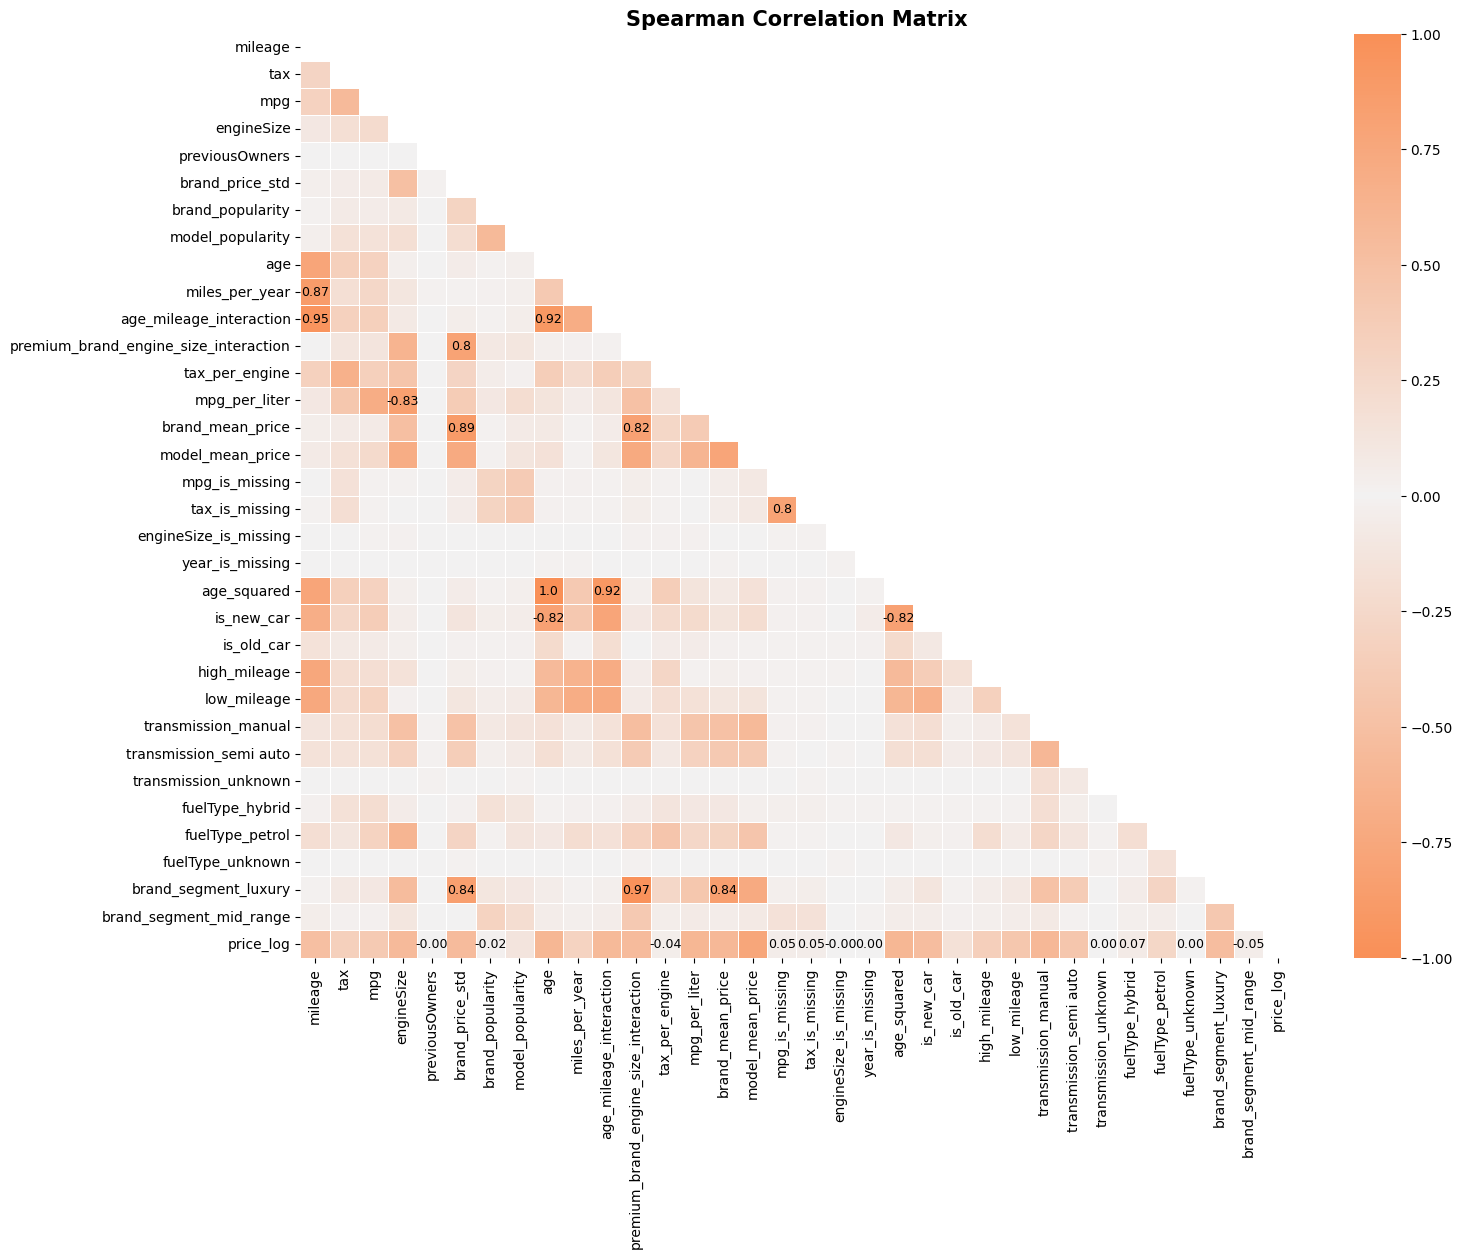

In [13]:
# create a Series for y_train_log with proper index
y_train_log_series = pd.Series(
    y_train_log, 
    index=X_train_scaled.index, 
    name='price_log'
)

##### Spearman Correlation ####
# concatenate X_train_scaled and y_train_log_series
cor = pd.concat([X_train_scaled, y_train_log_series], axis=1).corr(method='spearman').round(2) #the method 'spearman' uses rank and handles all variable types in our set

TARGET_COL = 'price_log'
price_index = cor.columns.get_loc(TARGET_COL)

# Create custom annotation matrix for weak correlations
annot_matrix = np.full(cor.shape, "", dtype=object)
for i, col in enumerate(cor.index):
    corr_value = cor.loc[col, TARGET_COL]
    # Annotate only if |corr| < 0.1
    if abs(corr_value) < 0.1 and i != price_index:
        annot_matrix[price_index, i] = f"{corr_value:.2f}"
        
# Create main annotation matrix for strong correlations
# Annotate only if |corr| >= 0.8
mask_annot_main = np.absolute(cor.values) >= 0.8
# Exclude 'price' row and column from this matrix
mask_annot_main[:, price_index] = False
mask_annot_main[price_index, :] = False
annot_main = np.where(mask_annot_main, cor.values.astype(str), "")

# Create the final annotation matrix by combining the two logics
final_annot_matrix = annot_main.copy()
for i in range(cor.shape[0]):
    for j in range(cor.shape[1]):
        # If the main annotation is empty and the weak one has a value, use the weak value
        if final_annot_matrix[i, j] == "" and annot_matrix[i, j] != "":
            final_annot_matrix[i, j] = annot_matrix[i, j]

# Plotting
plt.figure(figsize=(16, 12))

# Create a custom diverging colormap based on orange tones
cmap = sns.diverging_palette(h_neg=30, h_pos=30, s=90, l=70, n=256, center="light", as_cmap=True) 

# Create a Mask to hide the upper triangle (to avoid redundancy)
mask = np.zeros_like(cor, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    data=cor,
    mask=mask,
    cmap=cmap,
    annot=final_annot_matrix, # combined annotation matrix
    fmt='s',                  # Format annotations as strings
    vmin=-1, vmax=1, center=0,# Ensure the scale is from -1 to 1, centered at 0
    linewidths=0.5,
    annot_kws={"fontsize": 9, "color": "black"},
)

plt.title('Spearman Correlation Matrix', fontsize=15, fontweight='bold')
plt.show()

Já tivemos a retirar algumas variáveis irrelevantes portanto o nosso foco aqui com Spearman é retirar variáveis redundantes
Vamos coemçar por retirar a variável que apresenta maior número de correlações muito fortes com outras variáveis (|corr| $\geq 0.8$). que no caso é **'bran_segment_luxury'**. ou *brand_price_std* tiramos o primeiro que apresenta mais correlações muito fortes
de seguida várias têm muita corr com 2 variáveis, portanto começamos com a variável de 2 corr forte que apresenta a mais forte portanto retiramos
**age_mileage_interaction** vou retirar porque tem 2 corr fortes

**is_new_car**     **brand_mean_price** 
Existem ainda variáveis que no máximo têm uma correlação muito forte com outra variável mas sabemos que por vezes essas variáveis são importantes para o modelo portanto não as retiramos já e deixamos os embedded methods escolher.
APAGAR

In [14]:
#APAGAR: TIRAR DA PART1 A CRIAÇÃO DESTA VARIÁVEL
for d in [X_train_scaled, X_val_scaled, X_test_scaled]:
    d.drop(columns='age_squared', errors='ignore', inplace=True)

In [19]:
# Drop redundant columns from all
redundant= ['brand_price_std', 'brand_segment_luxury', 'age_mileage_interaction'] 
for d in [X_train, X_val , X_test]:
    d.drop(columns=redundant, errors='ignore', inplace=True)

In [ ]:
# # ['mileage', 'tax', 'mpg', 'engineSize', 'brand_popularity',
#        'model_popularity', 'age', 'miles_per_year',
#        'premium_brand_engine_size_interaction', 'tax_per_engine',
#        'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc',
#        'mpg_is_missing', 'tax_is_missing', 'is_new_car', 'is_old_car',
#        'high_mileage', 'low_mileage', 'transmission_manual',
#        'transmission_semi auto', 'fuelType_hybrid', 'fuelType_petrol',
#        'brand_segment_mid_range'],


# PODE SAIR: TAX, brand_price_std, age, miles_per_year, mpg_is_missing, tax_is_missing, 'is_new_car', 'is_old_car', 'high_mileage', 'low_mileage', transmission_semi auto, fuelType_hybrid, brand_segment_luxury, brand_segment_mid_range
# TEM DE FICAR: mileage, MPG, engineSize, brand_popularity, model_popularity, Brand_target_enc, age_mileage_interaction, premium_brand_engine_size_interaction, tax_per_engine, mpg_per_liter, brand_model_target_enc, transmission_manual, fuelType_petrol
# #SÓ FALTA  'age_squared', 'age_mileage_interaction' QUE REITIREI

#APAGAR

Index(['mileage', 'tax', 'mpg', 'engineSize', 'brand_price_std',
       'brand_popularity', 'model_popularity', 'age', 'miles_per_year',
       'age_mileage_interaction', 'premium_brand_engine_size_interaction',
       'tax_per_engine', 'mpg_per_liter', 'Brand_target_enc',
       'brand_model_target_enc', 'mpg_is_missing', 'tax_is_missing',
       'is_new_car', 'is_old_car', 'high_mileage', 'low_mileage',
       'transmission_manual', 'transmission_semi auto', 'fuelType_hybrid',
       'fuelType_petrol', 'brand_segment_luxury', 'brand_segment_mid_range'],
      dtype='object')

Estamos só a considerar correlações fortes (|corr| $\geq 0.8$) para identificar variáveis que sejam mesmo redundantes e não arriscar eliminar features que não traziam multicolinearidade e eram importantes para o modelo.
APAGAR

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.2 |  Wrapper Methods</b></span>
    </h1>
</div>

APAGAR: Dizer que deixámos no notebook das experências RFE e também usámos no handout mas aqui decidimos ir por uma abordagem diferente

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.3 |  Embedded Methods</b></span>
    </h1>
</div>

#APAGAR 
O objetivo é evitar o bias de um único algoritmo.
O Meta-Ranking garante que apenas as features que todos os algoritmos (lineares e não lineares) concordam serem importantes chegam ao topo da lista ranked_features. Esta é a melhor forma de reduzir o bias de um único modelo na Feature Selection.
Se uma feature for consistentemente classificada como 1º, 2º, 1º, 2º, a soma será baixa.
    A lista final ranked_features é a ordenação por consenso, onde as features com a menor soma de ranks são consideradas as mais importantes por todo o conjunto de modelos.


Sim, os modelos LASSO e Elastic Net (e Ridge) são incluídos no Meta-Ranking de Importância, mesmo que já retirem variáveis sozinhos.

este for n_features in feature_range: pode ser visto como um wrapper method

O código começa com as 3 features mais importantes (n=3), treina e testa os 5 modelos (ElasticNet, ET, GB, RF, KNN) no conjunto de validação.Ele continua a adicionar a próxima feature mais importante da lista de consenso (n=4, n=5, etc.) e repete o treino e a validação.Objetivo: Otimizar o subset de features. O valor de $N$ que resultar no menor erro de validação (MAE) para cada modelo é o número ótimo de features para esse modelo.
O erro de validação (val_mae) permite encontrar o ponto de "doce" (sweet spot) onde o modelo tem a complexidade ideal, generalizando bem sem ser overfit ao ruído.

# diz-me uma coisa, quando faço feature importance, a importância tem de estar nos resultados obtidos para validation ne? não é para train, ou é?

tem uma componente wrapper na medida em que 

Também há uma separação clara entre LASSO e ELASTICNET e os outros modelos Porque uma coisa é Feature Selection Regularization methods e outra é Tree-based methods (FEATURE IMPORTANCE).

In [ ]:
# Lasso Regularization (L1) 
lasso_model = Lasso(random_state=37, max_iter=10000)
lasso_model.fit(X_train, y_train)
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train.columns)
lasso_importance = lasso_coefs.abs().sort_values(ascending=False)

# Ridge Regularization (L2) 
ridge_model = Ridge(random_state=37, max_iter=10000)
ridge_model.fit(X_train, y_train)
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train.columns)
ridge_importance = ridge_coefs.abs().sort_values(ascending=False)

# ElasticNet Regularization (L1 + L2)
elasticnet_model = ElasticNet(l1_ratio=0.5, random_state=37, max_iter=10000)
elasticnet_model.fit(X_train, y_train)
elasticnet_coefs = pd.Series(elasticnet_model.coef_, index=X_train.columns)
elasticnet_importance = elasticnet_coefs.abs().sort_values(ascending=False)

# GB - Native Feature Importance
gb_base = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=37)
gb_base.fit(X_train, y_train)
gb_importance = pd.Series(gb_base.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# RF - Native Feature Importance
rf_base = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
rf_base.fit(X_train, y_train)
rf_importance = pd.Series(rf_base.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# ExtraTrees - Native Feature Importance
et_base = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
et_base.fit(X_train, y_train)
et_importance = pd.Series(et_base.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# # KNN - Mutual Information (captures non-linear relationships)
# mi_scores = mutual_info_regression(X_train, y_train, random_state=37)
# knn_importance = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# Features eliminated by Lasso
lasso_eliminated = lasso_coefs[lasso_coefs == 0].index.tolist()
if lasso_eliminated:
    print(f"\n Features eliminated by Lasso: {lasso_eliminated}")
else:
    print(f"\n Lasso kept all features")

# Features eliminated by ElasticNet
elasticnet_eliminated = elasticnet_coefs[elasticnet_coefs == 0].index.tolist()
if elasticnet_eliminated:
    print(f" Features eliminated by ElasticNet: {elasticnet_eliminated}")
else:
    print(f" ElasticNet kept all features")

print("\n Feature importance calculated for all 7 methods")

In [ ]:
# Create ranks for each model (1 = most important)
elasticnet_ranks = pd.Series(range(1, len(elasticnet_importance) + 1), index=elasticnet_importance.index)
et_ranks = pd.Series(range(1, len(et_importance) + 1), index=et_importance.index)
gb_ranks = pd.Series(range(1, len(gb_importance) + 1), index=gb_importance.index)
rf_ranks = pd.Series(range(1, len(rf_importance) + 1), index=rf_importance.index)
knn_ranks = pd.Series(range(1, len(knn_importance) + 1), index=knn_importance.index)

# Combine and sort
feature_ranks = (elasticnet_ranks + et_ranks + gb_ranks + rf_ranks + knn_ranks).sort_values()

# Final sorted list
ranked_features = feature_ranks.index.tolist()
print(ranked_features)

# Model configurations
model_configs = {
    'ELASTICNET': lambda: ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=37, max_iter=10000),
    'ET': lambda: ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1),
    'GB': lambda: GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.06, random_state=37),
    'RF': lambda: RandomForestRegressor(n_estimators=100, max_depth=15, random_state=37, n_jobs=-1),
    'KNN': lambda: KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1)
}

# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': ranked_features,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}

# Test from 3 to all features
feature_range = range(3, len(ranked_features))

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = ranked_features[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train[features], y_train)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train, model.predict(X_train[features]))
        val_mae = mean_absolute_error(y_val, model.predict(X_val[features]))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

    # Show progress
    print(f"n={n_features:2d} | ElasticNet: {best_results['ELASTICNET']['val_history'][-1]:,.0f} | ExtraTrees: {best_results['ET']['val_history'][-1]:,.0f} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f}")


In [ ]:
final_features = ['model_mean_price',
'engineSize',
'age_mileage_interaction',
'age_squared',
'mpg',
'mpg_per_liter',
'transmission_manual',
'premium_brand_engine_size_interaction',
'model_popularity',
'tax_per_engine',
'mileage',
'brand_mean_price',
'brand_popularity',
'brand_segment_mid_range',
'fuelType_petrol',
'transmission_semi auto']

final_features_sorted_rf = (
    rf_importance
    .loc[final_features]
    .sort_values(ascending=False)
    .index
    .tolist()
)


feature_range = range(3, len(final_features))

best_results ={}
# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': final_features_sorted_rf,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = final_features_sorted_rf[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train[features], y_train)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train, model.predict(X_train[features]))
        val_mae = mean_absolute_error(y_val, model.predict(X_val[features]))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

 # Show progress
    print(f"n={n_features:2d} | ElasticNet: {best_results['ELASTICNET']['val_history'][-1]:,.0f} | ExtraTrees: {best_results['ET']['val_history'][-1]:,.0f} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f}")


In [ ]:
# O principal motivo para usar o ExtraTreesRegressor para Feature Selection é a sua capacidade de fornecer uma pontuação de Importância da Característica (Feature Importance), baseada na métrica Gini Importance

In [12]:
# Drop `paintQuality%`, `previousOwners`, `miles_per_year`, `transmission_semi auto`, `transmission_unknown`, `fuelType_hybrid`, `fuelType_petrol`, `fuelType_unknown`
X_train.drop(columns=['paintQuality%', 'previousOwners', 'miles_per_year', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown'], inplace=True)
X_val.drop(columns=['paintQuality%', 'previousOwners', 'miles_per_year', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown'], inplace=True)
X_test.drop(columns=['paintQuality%', 'previousOwners', 'miles_per_year', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown'], inplace=True)

# <span style="color: #ffffff;">3 | Regression Benchmarking</span>

<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>


<br>
<div style="
  border: 2px solid #42A5F5;
  border-radius: 12px;
  background-color: #E3F2FD;
  padding: 14px;
  font-family: 'Segoe UI', sans-serif;
  color: #0D47A1;
  box-shadow: 2px 2px 8px rgba(33, 150, 243, 0.15);
">
  🚀 <b>O que é preciso:</b><br> 

- Explanation of model assessment **strategy** and **metrics** used
- **Optimization** efforts: presentation, results and discussion
- **Comparison** of performance between candidate models
 - Identify the type of problem and select the relevant algorithms.
 - Select one model assessment strategy to use throughout your work. Which metrics are you using to evaluate your model and why?
 - Train at least 1 model using the train dataset and obtain predictions for the test dataset.(Extra 1 point) Be on the Top-5 Best Groups in the Kaggle Competition
 - model assessment strategy (holdout, cross validation, etc...) and algorithms (minimum of 5 covered in class) used
 - rationale for choice of evaluation metric(s) and interpretation of results


APAGAR
</div>


APAGAR:


Pinball Loss 0.25:
 ESTA É A IDEIA DO NEGÓCIO:
O seu objetivo é: "Prever valores abaixo do real do que acima".Quando a previsão ($\hat{y}$) é inferior ao valor real ($y$) $\rightarrow$ o seu custo é mais baixo.Quando a previsão ($\hat{y}$) é superior ao valor real ($y$) $\rightarrow$ o seu custo é mais alto. No entanto, para a Cars 4 You, o erro mais crítico é quando se prevê demasiado alto ($\hat{y} > y$) e acabam por pagar a mais (FICA DIFÍCIL DE REVENDER O CARRO)


RMSE: Dá maior peso a erros maiores devido ao quadrado. Também em unidades da variável alvo (£).	Boa para penalizar erros grandes. Se um erro de £10.000 for muito mais crítico do que dois erros de £5.000, o RMSE será a métrica mais relevante.

In [ ]:
# EVALUATION FUNCTION 
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    scores = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val, y_val_pred),
        'Train Pinball (α=0.25)': mean_pinball_loss(y_train, y_train_pred, alpha=0.25),
        'Val Pinball (α=0.25)': mean_pinball_loss(y_val, y_val_pred, alpha=0.25)
    }
    return scores

# MODELS AND HYPERPARAMETER GRIDS
models_and_grids = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {} # Here we have no hyperparameters to tune
    },
    "ElasticNet": {
        "model": ElasticNet(random_state=37, max_iter=5000),
        "params": {
            'alpha': [0.2, 0.8], # Controls the regularization strength
            'l1_ratio': [0.5, 0.9],  # Mix between L1 and L2
        }
    },
    "SVR": {
        "model": SVR(epsilon=0.5),
        "params": {
            'C': [1, 10],      # Regularization parameter
            'gamma': ['scale', 'auto'] # Kernel coefficient
        }
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(p=1, n_jobs=-1),
        "params": {
            'n_neighbors': [3, 7],  # Number of neighbors to consider for prediction
            'weights': ['distance', 'uniform'], # the way to weight the neighbors
        }
    
    },
    "MLP Regressor": {
    "model": MLPRegressor(random_state=37, max_iter=500), # max_iter é importante  #it is usually better to have higher number of hidden layers
    "params": {
        'hidden_layer_sizes': [(), (50, 50)], # 1 ou 2 camadas
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'learning_rate_init': [0.001, 0.01]
        }
    } 
}


# __Some rule of thumbs:__
# -	The number of hidden neurons should be between the size of the input layer and the size of the output layer
# -	The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer
# -	The number of hidden neurons should be less than twice the size of the input layer

# "Decision Tree": {
#         "model": DecisionTreeRegressor(random_state=37),
#         "params": {
#             'max_depth': [5, 10, None], # Max depth to control overfitting
#             'min_samples_leaf': [2, 5]  # Min samples per leaf
#         }
#     },
#     "Random Forest": {
#         "model": RandomForestRegressor(random_state=37, n_jobs=-1),
#         "params": {
#             'n_estimators': [100],      # Number of trees
#             'max_depth': [10, 20],      # Max depth of trees
#             'min_samples_leaf': [2, 4, 6] # Min samples per leaf
#         }


models_and_grids = {
    "Elastic Net": {
        "model": ElasticNet(random_state=37, max_iter=10000),
        "params": {
            'alpha': [0.8731, 0.8732, 0.8733, 0.8734, 0.8735, 0.8736, 0.8737, 0.8738, 0.8739], 
            'l1_ratio': [0.91]
        } 
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(n_jobs=-1),
        "params": {
            'n_neighbors': [8],
            'weights': ['distance'],
            'p': [1]
        }
    },
    "Extra Tree": {
        "model": ExtraTreesRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250],
            'max_depth': [22],
            'min_samples_leaf': [2],
            'max_features': [None]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [450, 460, 470, 480, 490, 500],
            'max_depth': [19, 20],
            'min_samples_leaf': [1, 2, 3],
            'max_features': ['log2', 'sqrt']
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=37),
        "params": {
            'learning_rate': [0.01, 0.02],
            'max_depth': [11],
            'min_samples_leaf': [2],
            'n_estimators': [970, 980, 990, 1000],
            'subsample': [0.7, 0.75]
        }
    }
}

--- Processing model: Linear Regression ---
  Params: {} -> Val MAE: 3584.3732
Best validation MAE for Linear Regression: 3584.3732

--- Processing model: ElasticNet ---
  Params: {'alpha': 0.1, 'l1_ratio': 0.1} -> Val MAE: 3574.3183
  Params: {'alpha': 0.1, 'l1_ratio': 0.5} -> Val MAE: 3560.8787
  Params: {'alpha': 0.1, 'l1_ratio': 0.9} -> Val MAE: 3574.9216
  Params: {'alpha': 1.0, 'l1_ratio': 0.1} -> Val MAE: 4612.7643
  Params: {'alpha': 1.0, 'l1_ratio': 0.5} -> Val MAE: 4132.4925
  Params: {'alpha': 1.0, 'l1_ratio': 0.9} -> Val MAE: 3580.9394
  Params: {'alpha': 10.0, 'l1_ratio': 0.1} -> Val MAE: 6287.6545
  Params: {'alpha': 10.0, 'l1_ratio': 0.5} -> Val MAE: 5971.1202
  Params: {'alpha': 10.0, 'l1_ratio': 0.9} -> Val MAE: 4711.4814
Best validation MAE for ElasticNet: 3560.8787

--- Processing model: SVR ---
  Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -> Val MAE: 5439.0040
  Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'} -> Val MAE: 5390.3855
  Params: {'C': 10, 'ga

,Model,Val MAE,Train MAE,Val RMSE,Train RMSE,Val Pinball (α=0.5),Train Pinball (α=0.5),Best Params
6,Gradient Boosting,1414.714125,1228.131137,2332.313310,1840.510040,707.357063,614.065568,"{'learning_rate': 0.1, 'max_depth': 7, 'min_sa..."
4,Random Forest,1425.652334,830.480952,2535.256951,1516.135196,712.826167,415.240476,"{'max_depth': 20, 'min_samples_leaf': 2, 'n_es..."
5,K-Neighbors,1632.203881,19.121401,2860.780896,189.414295,816.101940,9.560701,"{'n_neighbors': 7, 'weights': 'distance'}"
3,Decision Tree,1690.032022,1130.649342,2937.579784,2053.653981,845.016011,565.324671,"{'max_depth': None, 'min_samples_leaf': 5}"
2,SVR,2798.116590,2758.658422,4800.256846,4723.911399,1399.058295,1379.329211,"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}"
1,ElasticNet,3560.878693,3491.782561,5451.197579,5323.794859,1780.439346,1745.891281,"{'alpha': 0.1, 'l1_ratio': 0.5}"
0,Linear Regression,3584.373188,3509.675604,5426.879092,5287.203839,1792.186594,1754.837802,{}


In [ ]:
#    "Gradient Boosting": {
#         "model": GradientBoostingRegressor(random_state=37),        
#         "params": {
#             'learning_rate': [0.1],
#             'max_depth': [3,7],
#             'min_samples_leaf': [3,5],
#             'n_estimators': [200],
#             'subsample': [1.0, 0.8]
#         }
#     }

In [15]:
#Combining training and validation datasets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

print(f"Final training set dimensions (X): {X_train_full.shape}")
print(f"Final training set dimensions (y): {y_train_full.shape}")

# Train the Final Model with the Best Hyperparameters
best_params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'min_samples_leaf': 3,
    'n_estimators': 200,
    'subsample': 1.0,
    'random_state': 37  # Add a random_state for reproducible results
}

# Instantiate the GradientBoostingRegressor with the best parameters
final_model = GradientBoostingRegressor(**best_params)

# Train the model on the full combined dataset
final_model.fit(X_train_full, y_train_full)

# Make Predictions on the Test Set
test_predictions = final_model.predict(X_test)

# Create and Export the Submission File
print("Creating the submission file...")
submission_df = pd.DataFrame({
    'carID': X_test.index,
    'price': test_predictions
})

# Export to a CSV file without the DataFrame index
submission_df.to_csv("./project_data/Group37_Version1.csv", index=False)
print("\nSubmission file 'Group37_Version1.csv' exported successfully!")
print("First 5 rows of the submission file:")
print(submission_df.head())

Final training set dimensions (X): (75956, 8)
Final training set dimensions (y): (75956,)
Creating the submission file...

Submission file 'Group37_Version1.csv' exported successfully!
First 5 rows of the submission file:
    carID         price
0   89856  11049.956294
1  106581  21575.734207
2   80886  12659.515303
3  100174  17039.134083
4   81376  24774.715679



<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>


<br>
<div style="
  border: 2px solid #42A5F5;
  border-radius: 12px;
  background-color: #E3F2FD;
  padding: 14px;
  font-family: 'Segoe UI', sans-serif;
  color: #0D47A1;
  box-shadow: 2px 2px 8px rgba(33, 150, 243, 0.15);
">
  🚀 <b>O que é preciso:</b><br> 

**Open-Ended Section**
 - Objectives for the Section and description of the actions taken <br>
 - Results and discussion of main findings → key takeaways
 Note: for example using a feature selection technique not covered in class on your regular pipeline is not sufficient, but explicitly comparing different feature sets would be. <br>

 Describe your strategy for the additional insights objective. This section is separated into different components:
- Formulation and Adequacy of the Objectives: 0.5v
-  Difficulty of tasks: 1v
- Correctness/efficiency of implementation: 1v
- Discussion of results: 1v


APAGAR
</div>

In [ ]:
#JUNTAR TUDO NO FINAL E FAZER UM MODELO COM TODOS OS DADOS
# Combined train+val for final model training
X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_full_array    = np.concatenate([y_train_array, y_val_array])
y_train_full_log      = np.concatenate([y_train_log, y_val_log])

In [ ]:
#APAGAR: Parte extra
# LINEAR REGRESSION
lr = LinearRegression()
lr.fit(X_train, y_train)
y_val_pred_lr = lr.predict(X_val)

# Save model as pickle file (save as compressed file - sav.gz)
import pickle
with open('./linear_regression_model.sav.gz', 'wb') as f:
    pickle.dump(lr, f)

#APAGAR: NO FIM É PRECISO ISTO PARA A APP
# Save model
with gzip.open('./project_data/linear_regression_model.sav.gz', 'wb') as f:
    joblib.dump(lr_model, f)

In [ ]:

# # Combined train+val for final model training
# X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0)
# y_train_full_array    = np.concatenate([y_train_array, y_val_array])
# y_train_full_log      = np.concatenate([y_train_log, y_val_log])